In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Libraries
import pandas as pd
import os

from src.data import prep_data as prep
from src.models import model_schemata as schema
from src.models import build_model as build

In [56]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [57]:
# reading csv from files into dict
data = {}
data['e_ksea'] = pd.read_csv('data/processed/ebdt_data/sub_network_p/e_ksea.csv')
data['p_fc'] = pd.read_csv('data/processed/ebdt_data/sub_network_p/p_fc.csv')

Penalise low target count KSEA values

In [58]:
prep.scale_ksea_column(data['e_ksea'], 'prob', 'tc')
data['e_ksea'].loc[data['e_ksea']['tc'] == 2]

,enzyme,sample,tc,value,prob,p_dec,p_inc
61,FYN,AC220,2.0,dec,0.520397,0.533995,0.001000
62,FYN,AT13148,2.0,inc,0.595574,0.001000,0.659290
63,FYN,AZ20,2.0,inc,0.581485,0.001000,0.635809
64,FYN,AZD1480,2.0,inc,0.512778,0.001000,0.521297
65,FYN,AZD3759,2.0,dec,0.605015,0.675026,0.001000
...,...,...,...,...,...,...,...
422,PTPRR,Torin,2.0,inc,0.797276,0.001000,0.995460
423,PTPRR,Trametinib,2.0,dec,0.774675,0.957792,0.001000
424,PTPRR,U73122,2.0,dec,0.658227,0.763712,0.001000
425,PTPRR,Ulixertinib,2.0,inc,0.772729,0.001000,0.954549


<Axes: >

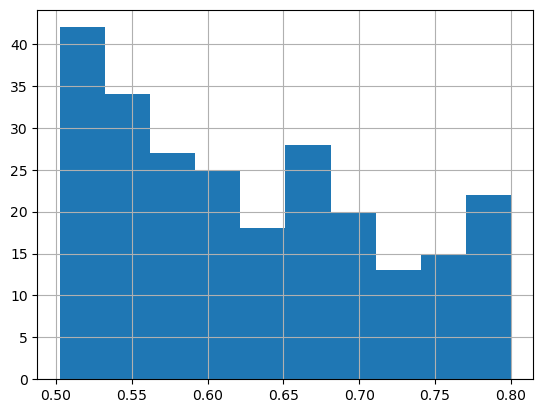

In [59]:
data['e_ksea'].loc[data['e_ksea']['tc'] == 2, 'prob'].hist()

In [60]:
# Calculate 'p_dec' and 'p_inc' columns based on conditions
data['e_ksea']['p_dec'] = data['e_ksea'].apply(lambda row: row['prob'] if row['value'] == 'dec' else 0.001, axis=1)
data['e_ksea']['p_inc'] = data['e_ksea'].apply(lambda row: row['prob'] if row['value'] == 'inc' else 0.001, axis=1)
data['e_ksea'].loc[data['e_ksea']['tc'] == 2]

,enzyme,sample,tc,value,prob,p_dec,p_inc
61,FYN,AC220,2.0,dec,0.520397,0.520397,0.001000
62,FYN,AT13148,2.0,inc,0.595574,0.001000,0.595574
63,FYN,AZ20,2.0,inc,0.581485,0.001000,0.581485
64,FYN,AZD1480,2.0,inc,0.512778,0.001000,0.512778
65,FYN,AZD3759,2.0,dec,0.605015,0.605015,0.001000
...,...,...,...,...,...,...,...
422,PTPRR,Torin,2.0,inc,0.797276,0.001000,0.797276
423,PTPRR,Trametinib,2.0,dec,0.774675,0.774675,0.001000
424,PTPRR,U73122,2.0,dec,0.658227,0.658227,0.001000
425,PTPRR,Ulixertinib,2.0,inc,0.772729,0.001000,0.772729


In [61]:
e_ksea_ad = prep.expand_ad_cpd(data['e_ksea'], 'value')
p_fc_ad = prep.expand_ad_cpd(data['p_fc'], 'value')
e_ksea_ad

,enzyme,sample,tc,value,prob,p_dec,p_inc,p_base
0,ABL1,AC220,10.0,dec,0.649536,0.649536,0.001000,0.349464
1,ABL1,AC220,10.0,inc,0.649536,0.001000,0.649536,0.349464
2,ABL1,AT13148,10.0,dec,0.591795,0.591795,0.001000,0.407205
3,ABL1,AT13148,10.0,inc,0.591795,0.001000,0.591795,0.407205
4,ABL1,AZ20,10.0,dec,0.652697,0.652697,0.001000,0.346303
...,...,...,...,...,...,...,...,...
971,SRC,U73122,12.0,inc,0.551325,0.001000,0.551325,0.447675
972,SRC,Ulixertinib,12.0,dec,0.602812,0.602812,0.001000,0.396188
973,SRC,Ulixertinib,12.0,inc,0.602812,0.001000,0.602812,0.396188
974,SRC,Vemurafenib,12.0,dec,0.797541,0.797541,0.001000,0.201459


In [62]:
# Mapping data to Problog predicates
# make sure to delete 'base' from schemata and AnnotatedDisjunctionClauseTemplate
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(e_ksea_ad, 'enzyme', 'sample', 'value')
predicates['e_ksea'].add_ad_probabilities(e_ksea_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(p_fc_ad, 'phosphosite', 'sample', 'value')
predicates['p_fc'].add_ad_probabilities(p_fc_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')

In [63]:
model_lfi = 'models/ebdt_data/sub_network/p_model/p_model_lfi_exp10.pl'
for predicate in predicates: 
    ad_generator = build.ProblogStatementGenerator(predicates[predicate])
    clauses = ad_generator.generate_ad_clauses(type='boolean')
    clauses.extend(ad_generator.generate_ad_clauses(type='domain'))
    build.insert_statements(model=model_lfi, statements=clauses, location='%% p1::{}'.format(predicate)) # insert into Problog file

In [64]:
data['e_ksea'].to_csv('data/processed/ebdt_data/sub_network_p/e_ksea_penalised.csv', index=False)